In [167]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import datetime 
import warnings
import csv
warnings.simplefilter(action='ignore', category=FutureWarning)
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


#### Import data

In [168]:
items = pd.read_csv('items.csv')
items_cat = pd.read_csv('item_categories.csv')
sales_train = pd.read_csv('sales_train.csv')
sales_test = pd.read_csv('test.csv')
shops  = pd.read_csv('shops.csv')

#### Data cleaning and exploration

In [169]:
sales_train.shape

(2935849, 6)

In [170]:
shops.columns

Index(['shop_name', 'shop_id'], dtype='object')

In [171]:
sales_test.shape

(214200, 3)

In [172]:
display(sales_train, items_cat, items, shops)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


#### Joining the datasets

In [173]:
df = pd.merge(items, sales_train)

In [174]:
df1=pd.merge(items_cat, df)

In [175]:
df2=pd.merge(shops, df1)

In [176]:
train = df2
train.head()

print(train.shape)

(2935849, 10)


In [177]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   shop_name           object 
 1   shop_id             int64  
 2   item_category_name  object 
 3   item_category_id    int64  
 4   item_name           object 
 5   item_id             int64  
 6   date                object 
 7   date_block_num      int64  
 8   item_price          float64
 9   item_cnt_day        float64
dtypes: float64(2), int64(4), object(4)
memory usage: 246.4+ MB


#### The number of rows of train and trainset1 are same 2935849, which shows that merge was successful.

#### Descriptive Statistics

In [178]:
train.describe()

,shop_id,item_category_id,item_id,date_block_num,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,3.300173e+01,4.000138e+01,1.019723e+04,1.456991e+01,8.908532e+02,1.242641e+00
std,1.622697e+01,1.710076e+01,6.324297e+03,9.422988e+00,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,2.200000e+01,2.800000e+01,4.476000e+03,7.000000e+00,2.490000e+02,1.000000e+00
50%,3.100000e+01,4.000000e+01,9.343000e+03,1.400000e+01,3.990000e+02,1.000000e+00
75%,4.700000e+01,5.500000e+01,1.568400e+04,2.300000e+01,9.990000e+02,1.000000e+00
max,5.900000e+01,8.300000e+01,2.216900e+04,3.300000e+01,3.079800e+05,2.169000e+03


#### In the statistical summary, notice that an item has a negative price which represents a mistake, also notice that item_cnt_day has a negative value which shows that there wasn't any sale that day. It shows -1 porbably because the products were returned. These issues will be fixed later during exploration.

### To check for missing values

In [179]:
train.isna().sum()

shop_name             0
shop_id               0
item_category_name    0
item_category_id      0
item_name             0
item_id               0
date                  0
date_block_num        0
item_price            0
item_cnt_day          0
dtype: int64

#### The data set does not contain any missing values

### To check the dimensions in categorical features

In [180]:
train['shop_name'].unique()

array(['!Якутск Орджоникидзе, 56 фран', '!Якутск ТЦ "Центральный" фран',
       'Адыгея ТЦ "Мега"', 'Балашиха ТРК "Октябрь-Киномир"',
       'Волжский ТЦ "Волга Молл"', 'Вологда ТРЦ "Мармелад"',
       'Воронеж (Плехановская, 13)', 'Воронеж ТРЦ "Максимир"',
       'Воронеж ТРЦ Сити-Парк "Град"', 'Выездная Торговля',
       'Жуковский ул. Чкалова 39м?', 'Жуковский ул. Чкалова 39м²',
       'Интернет-магазин ЧС', 'Казань ТЦ "Бехетле"',
       'Казань ТЦ "ПаркХаус" II', 'Калуга ТРЦ "XXI век"',
       'Коломна ТЦ "Рио"', 'Красноярск ТЦ "Взлетка Плаза"',
       'Красноярск ТЦ "Июнь"', 'Курск ТЦ "Пушкинский"',
       'Москва "Распродажа"', 'Москва МТРЦ "Афи Молл"',
       'Москва Магазин С21', 'Москва ТК "Буденовский" (пав.А2)',
       'Москва ТК "Буденовский" (пав.К7)', 'Москва ТРК "Атриум"',
       'Москва ТЦ "Ареал" (Беляево)', 'Москва ТЦ "МЕГА Белая Дача II"',
       'Москва ТЦ "МЕГА Теплый Стан" II',
       'Москва ТЦ "Новый век" (Новокосино)', 'Москва ТЦ "Перловский"',
       'Москва Т

In [181]:
train['item_category_name'].unique()

array(['PC - Гарнитуры/Наушники', 'Аксессуары - PS2', 'Аксессуары - PS3',
       'Аксессуары - PS4', 'Аксессуары - PSP', 'Аксессуары - PSVita',
       'Аксессуары - XBOX 360', 'Игровые консоли - PS3',
       'Игровые консоли - PSP', 'Игровые консоли - PSVita',
       'Игровые консоли - XBOX 360', 'Игры - PS3', 'Игры - PSP',
       'Игры - PSVita', 'Игры - XBOX 360', 'Игры - Аксессуары для игр',
       'Игры PC - Дополнительные издания',
       'Игры PC - Коллекционные издания', 'Игры PC - Стандартные издания',
       'Карты оплаты - Live!', 'Карты оплаты - PSN', 'Кино - Blu-Ray',
       'Кино - Blu-Ray 3D', 'Кино - DVD', 'Кино - Коллекционное',
       'Книги - Аудиокниги', 'Книги - Аудиокниги 1С',
       'Книги - Методические материалы 1С',
       'Музыка - CD локального производства',
       'Музыка - CD фирменного производства', 'Музыка - MP3',
       'Музыка - Музыкальное видео', 'Музыка - Подарочные издания',
       'Подарки - Гаджеты, роботы, спорт', 'Подарки - Мягкие игрушки',
  

In [182]:
train['item_name'].unique()

array(['Наушники PHILIPS SBC HC8680',
       'Pelican. Геймпад Nerf Wireless Controller PS2 (assorted colors)',
       'PS Move Controller (Контроллер движений)', ...,
       'LINKIN PARK  Reanimation', 'Ранетки (mp3-CD) (Jewel)',
       'Наш Сад, UPG с версии 6.0 до версии 10.0'], dtype=object)

In [183]:
train['item_id'].unique()

array([16255,  5740,  5570, ...,  4426, 18018, 16270], dtype=int64)

In [184]:
train['shop_name'].nunique()

60

#### This shows that each shop_name has an assigned shop_id

In [185]:
train['item_category_name'].nunique()

84

In [186]:
train['item_name'].nunique()

21807

In [187]:
train['item_id'].nunique()

21807

#### This shows that each item_name has an assigned item_id

### To copy the train data set

In [188]:
train_set = train.copy()

### To explore the dataset (EDA)

In [189]:
corrmat=train_set.corr()
corrmat

,shop_id,item_category_id,item_id,date_block_num,item_price,item_cnt_day
shop_id,1.000000,0.019380,0.029396,0.019273,-0.024034,-0.005230
item_category_id,0.019380,1.000000,0.369431,0.029128,-0.253554,0.014768
item_id,0.029396,0.369431,1.000000,0.009356,-0.134104,0.016650
date_block_num,0.019273,0.029128,0.009356,1.000000,0.095010,0.009402
item_price,-0.024034,-0.253554,-0.134104,0.095010,1.000000,0.011197
item_cnt_day,-0.005230,0.014768,0.016650,0.009402,0.011197,1.000000


<AxesSubplot:>

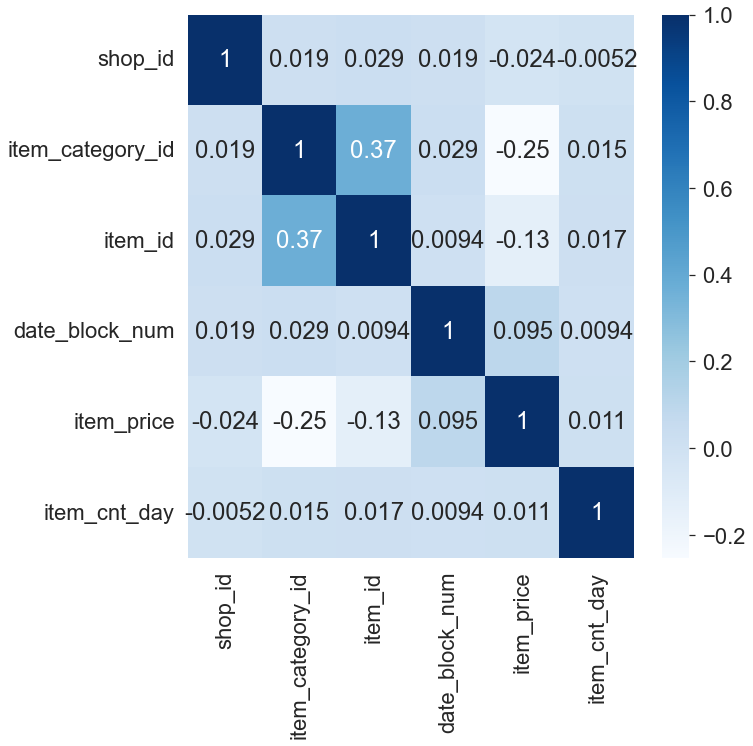

In [190]:
plt.figure(figsize=(10, 10))
sns.set(font_scale=2)
sns.heatmap(train_set.corr(), annot=True, cmap="Blues", fmt= ".2g")

#### Imputing the negative item price.

In [191]:
negative_price=train_set[train_set["item_price"] < 0]
negative_price


,shop_name,shop_id,item_category_name,item_category_id,item_name,item_id,date,date_block_num,item_price,item_cnt_day
1644072,"Москва ТЦ ""Серебряный Дом""",32,Игры - PS3,19,"DmC Devil May Cry [PS3, русские субтитры]",2973,15.05.2013,4,-1.0,1.0


There is only one record with negative price. Lets find the price of the item sold in the same shop during the same month, so we can imupte the value

In [192]:
price_2973=train_set[(train_set["shop_id"]== 32) & (train_set["item_category_name"]=="Игры - PS3") & (train_set["item_id"]== 2973 ) & (train_set["date_block_num"]== 4)]
price_2973

,shop_name,shop_id,item_category_name,item_category_id,item_name,item_id,date,date_block_num,item_price,item_cnt_day
1644071,"Москва ТЦ ""Серебряный Дом""",32,Игры - PS3,19,"DmC Devil May Cry [PS3, русские субтитры]",2973,23.05.2013,4,1249.0,1.0
1644072,"Москва ТЦ ""Серебряный Дом""",32,Игры - PS3,19,"DmC Devil May Cry [PS3, русские субтитры]",2973,15.05.2013,4,-1.0,1.0
1644073,"Москва ТЦ ""Серебряный Дом""",32,Игры - PS3,19,"DmC Devil May Cry [PS3, русские субтитры]",2973,06.05.2013,4,2499.0,1.0


#### Lets replace the price of the item with the average of two same items sold in the same month in the same shop

In [193]:
price_mean=price_2973[(price_2973.shop_id==32)&(price_2973.item_id==2973)&(price_2973.date_block_num==4)&(price_2973.item_price>0)]
price_mean.item_price.mean()

1874.0

In [194]:
train_set.at[1644072,'item_price']= 1849

### Imputing the negative value for item_cnt_day.

In [195]:
negative_item_cnt_day=train_set[train_set["item_cnt_day"] < 0]
negative_item_cnt_day

,shop_name,shop_id,item_category_name,item_category_id,item_name,item_id,date,date_block_num,item_price,item_cnt_day
15728,"Адыгея ТЦ ""Мега""",2,Аксессуары - PS3,2,PS3: Контроллер игровой беспроводной серый мет...,5637,06.10.2013,9,2590.00,-1.0
15757,"Адыгея ТЦ ""Мега""",2,Аксессуары - PS3,2,PS3: Контроллер игровой беспроводной темно-кра...,5642,01.12.2013,11,2490.00,-1.0
15771,"Адыгея ТЦ ""Мега""",2,Аксессуары - PS3,2,PS3: Контроллер игровой беспроводной черный (D...,5643,02.01.2013,0,2385.21,-1.0
16462,"Адыгея ТЦ ""Мега""",2,Аксессуары - XBOX 360,6,X360: Super ZOOM [только для Kinect],7882,12.07.2013,6,1390.00,-1.0
16589,"Адыгея ТЦ ""Мега""",2,Аксессуары - XBOX 360,6,X360: Геймпад проводной чёрный - Controller BL...,7894,23.02.2014,13,1490.00,-1.0
...,...,...,...,...,...,...,...,...,...,...
2934435,"Ярославль ТЦ ""Альтаир""",59,Программы - 1С:Предприятие 8,73,1С:Бухгалтерия 8. Базовая версия,482,13.11.2013,10,3300.00,-1.0
2934499,"Ярославль ТЦ ""Альтаир""",59,Программы - 1С:Предприятие 8,73,1С:Предпр.8.2.Версия для обучения программиров...,791,01.02.2013,1,600.00,-1.0
2934524,"Ярославль ТЦ ""Альтаир""",59,Программы - 1С:Предприятие 8,73,1С:Управление торговлей 8. Базовая версия,835,05.03.2014,14,4600.00,-1.0
2934594,"Ярославль ТЦ ""Альтаир""",59,Программы - Для дома и офиса,75,ESET NOD32 Smart Security - продление лицензии...,3141,12.03.2014,14,1180.00,-1.0


There are 7356 rows which have the value of -1 for item_cnt_day, since our task is to predict the sales for the next month our focus should be on sales and not on the return. We will keep these rows in the data set because it can play a siginifacant factor to correctly predict and understand sales but we will replace the -1 with 0.

In [196]:
cond = train_set['item_cnt_day'] < 0
check= train_set.loc[cond,'item_cnt_day'] = 0
check


0

This shows we have successfully replaced all the -1's with 0's.¶

### To check for outliers

#### Outliers in item_price

Text(0.5, 1.0, 'Outliers in item_price')

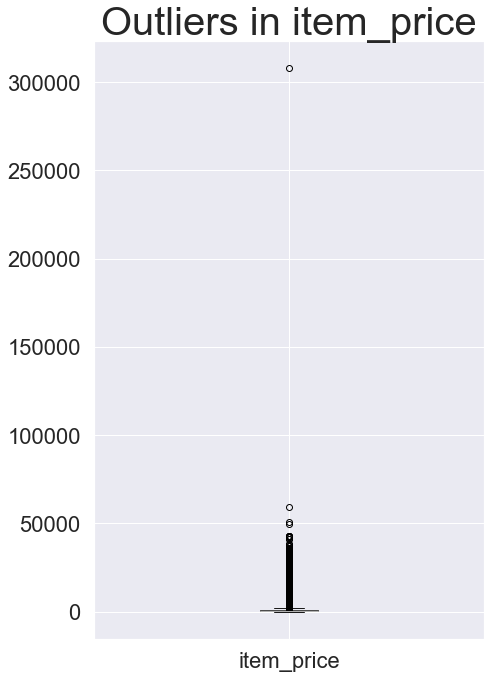

In [197]:
plt.figure(figsize=(7, 11))
train_set.boxplot(['item_price'])
plt.title('Outliers in item_price', fontsize = 40)

There are several in item_price outliers and these values should be explored further.

In [198]:
# To find the highest possible price within 3 standard deviation
print("Maximum possible price",train_set['item_price'].mean() + 3*train_set['item_price'].std())
print("Lowest possible price",train_set['item_price'].mean() - 3*train_set['item_price'].std())


Maximum possible price 6080.2527912390315
Lowest possible price -4298.545065560299


In [199]:
# To check the highest and lowest price in our dataset
hp=max(train_set.item_price)
print("Highest price :", hp)
lp=min(train_set.item_price)
print("Lowest price: ", lp)

Highest price : 307980.0
Lowest price:  0.07


In [200]:
# Since our lowest selling price is 0.07 we will check the outliers on the higher side
highest_price=train_set[train_set["item_price"] > 6080]
highest_price

,shop_name,shop_id,item_category_name,item_category_id,item_name,item_id,date,date_block_num,item_price,item_cnt_day
310,"!Якутск Орджоникидзе, 56 фран",0,Аксессуары - XBOX 360,6,Xbox 360 Kinect Sensor Xbox 360 CS/EL/HU/PL/RU...,7956,18.01.2013,0,6254.00,2.0
311,"!Якутск Орджоникидзе, 56 фран",0,Аксессуары - XBOX 360,6,Xbox 360 Kinect Sensor Xbox 360 CS/EL/HU/PL/RU...,7956,19.01.2013,0,6254.00,1.0
312,"!Якутск Орджоникидзе, 56 фран",0,Аксессуары - XBOX 360,6,Xbox 360 Kinect Sensor Xbox 360 CS/EL/HU/PL/RU...,7956,30.01.2013,0,6254.00,3.0
313,"!Якутск Орджоникидзе, 56 фран",0,Аксессуары - XBOX 360,6,Xbox 360 Kinect Sensor Xbox 360 CS/EL/HU/PL/RU...,7956,31.01.2013,0,6254.00,1.0
314,"!Якутск Орджоникидзе, 56 фран",0,Аксессуары - XBOX 360,6,Xbox 360 Kinect Sensor Xbox 360 CS/EL/HU/PL/RU...,7956,10.02.2013,1,6254.00,1.0
...,...,...,...,...,...,...,...,...,...,...
2929953,"Ярославль ТЦ ""Альтаир""",59,"Подарки - Гаджеты, роботы, спорт",62,Шпионский танк Spy-C Танк,21994,10.03.2013,2,6648.35,1.0
2935213,"Ярославль ТЦ ""Альтаир""",59,Программы - Для дома и офиса,75,Win 8.1 32-bit/64-bit Russian Russia Only DVD,7812,15.08.2015,31,6290.00,1.0
2935214,"Ярославль ТЦ ""Альтаир""",59,Программы - Для дома и офиса,75,Win 8.1 32-bit/64-bit Russian Russia Only DVD,7812,25.09.2015,32,6390.00,1.0
2935215,"Ярославль ТЦ ""Альтаир""",59,Программы - Для дома и офиса,75,Win 8.1 32-bit/64-bit Russian Russia Only DVD,7812,07.09.2015,32,6290.00,1.0


There are 28701 records with a price of higher than $6080, and it is not suggested to drop all these values, especially considering that the fact that the data pertains to many different products. It is highly possible that the shops have a wide range of products with different prices so we will only eliminate the extreme outliers for item_price

In [201]:
# To drop the outlier in item_price
train_set = train_set[train_set['item_price'] < 100000]

#### Outlier in item_cnt_day

Text(0.5, 1.0, 'Outliers in item_cnt_day')

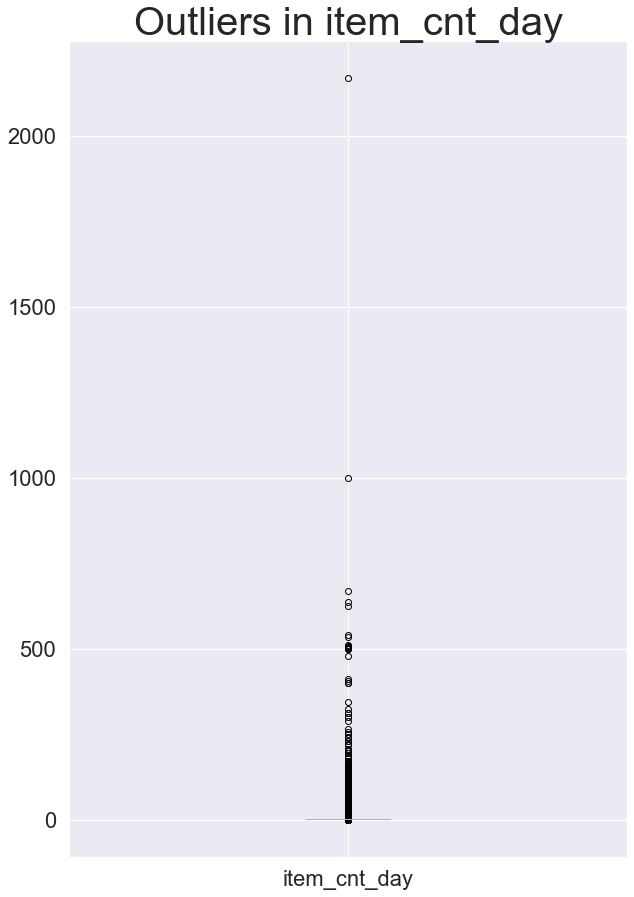

In [202]:
plt.figure(figsize=(10, 15))
train_set.boxplot(['item_cnt_day'])
plt.title('Outliers in item_cnt_day', fontsize = 40)


There are several outliers in item_cnt_day and should be explored further

In [203]:
# To find the highest and lowest possible nuber of products sold within 3 standard deviation
print("Maximum possible number of products sold",train_set['item_cnt_day'].mean() + 3*train_set['item_cnt_day'].std())
print("Lowest possible number of products sold",train_set['item_cnt_day'].mean() - 3*train_set['item_cnt_day'].std())


Maximum possible number of products sold 9.096348775703945
Lowest possible number of products sold -6.605929653188066


In [204]:
# To check for maximum and lowest number of products sold
hps=max(train_set.item_cnt_day)
print("Highest number of products sold :", hps)
lps=min(train_set.item_cnt_day)
print("Lowest number of products sold: ", lps)

Highest number of products sold : 2169.0
Lowest number of products sold:  0.0


In [205]:
# Since our lowest sold quantity is zero we will check the outliers on the higher side
highest_price=train_set[train_set["item_cnt_day"] > 9]
highest_price

,shop_name,shop_id,item_category_name,item_category_id,item_name,item_id,date,date_block_num,item_price,item_cnt_day
2556,"!Якутск Орджоникидзе, 56 фран",0,Игры PC - Стандартные издания,30,"Crysis 3 [PC, русская версия]",2445,22.02.2013,1,942.0,10.0
4943,"!Якутск Орджоникидзе, 56 фран",0,Кино - DVD,40,"ДЖЕНТЛЬМЕНЫ, УДАЧИ!",11000,16.02.2013,1,247.0,11.0
5993,"!Якутск Орджоникидзе, 56 фран",0,Кино - DVD,40,ОГРАБЛЕНИЕ КАЗИНО,16482,02.02.2013,1,247.0,10.0
15443,"!Якутск ТЦ ""Центральный"" фран",1,Чистые носители (штучные),82,Компактдиск Mirex CD-R 700 Мб 52x Slim case MA...,13345,25.01.2013,0,13.0,11.0
15464,"!Якутск ТЦ ""Центральный"" фран",1,Чистые носители (штучные),82,"Компактдиск Mirex DVD+R Dual Layer 8,5 Гб 8x S...",13351,17.01.2013,0,41.0,13.0
...,...,...,...,...,...,...,...,...,...,...
2933480,"Ярославль ТЦ ""Альтаир""",59,"Подарки - Сумки, Альбомы, Коврики д/мыши",71,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,05.10.2013,9,5.0,12.0
2933523,"Ярославль ТЦ ""Альтаир""",59,"Подарки - Сумки, Альбомы, Коврики д/мыши",71,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,28.12.2013,11,5.0,13.0
2933825,"Ярославль ТЦ ""Альтаир""",59,"Подарки - Сумки, Альбомы, Коврики д/мыши",71,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,29.11.2014,22,5.0,10.0
2933908,"Ярославль ТЦ ""Альтаир""",59,"Подарки - Сумки, Альбомы, Коврики д/мыши",71,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,14.02.2015,25,5.0,13.0


There are 11936 records on which the items sold is greater than 9. To reduce the impact of outliers and still be able to capture the impact of these sales we will only eliminate the extreme outliers for item_cnt_day.

In [206]:
# To drop the extreme outliers in item_cnt_day
train_set = train_set[train_set['item_cnt_day'] < 1000]

### Creating new features and extracting date

In [207]:
train_set['Sales'] = (train_set["item_price"] * train_set["item_cnt_day"])

In [208]:
train_set['date'] = pd.to_datetime(train_set['date'])
days = []
months = []
years = []

for day in train_set['date']:
    days.append(day.day)
for month in train_set['date']:
    months.append(month.month)    
for year in train_set['date']:
    years.append(year.year)

#### To find the year with highest sales

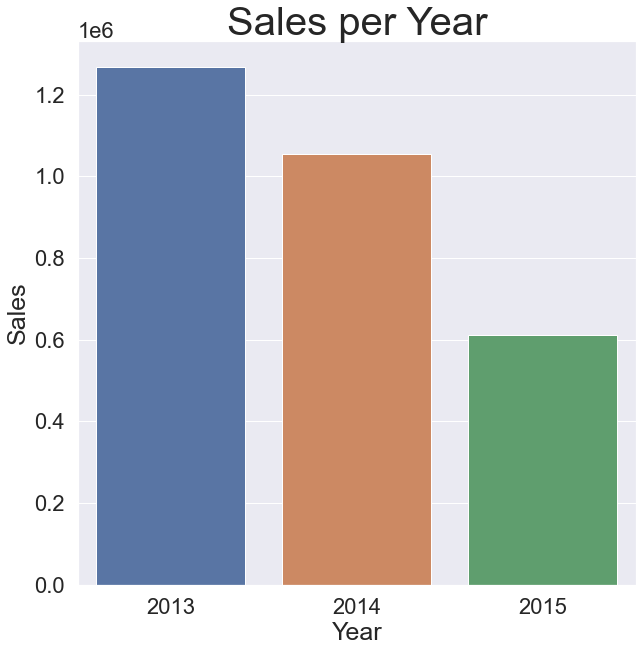

In [209]:
plt.figure(figsize=(10,10))
sns.countplot(years)
plt.title('Sales per Year', fontsize = 40)
plt.xlabel('Year', fontsize = 25)
plt.ylabel('Sales', fontsize = 25)
plt.show()

This shows 2013 has the highest total sales.

### To find the highest selling product

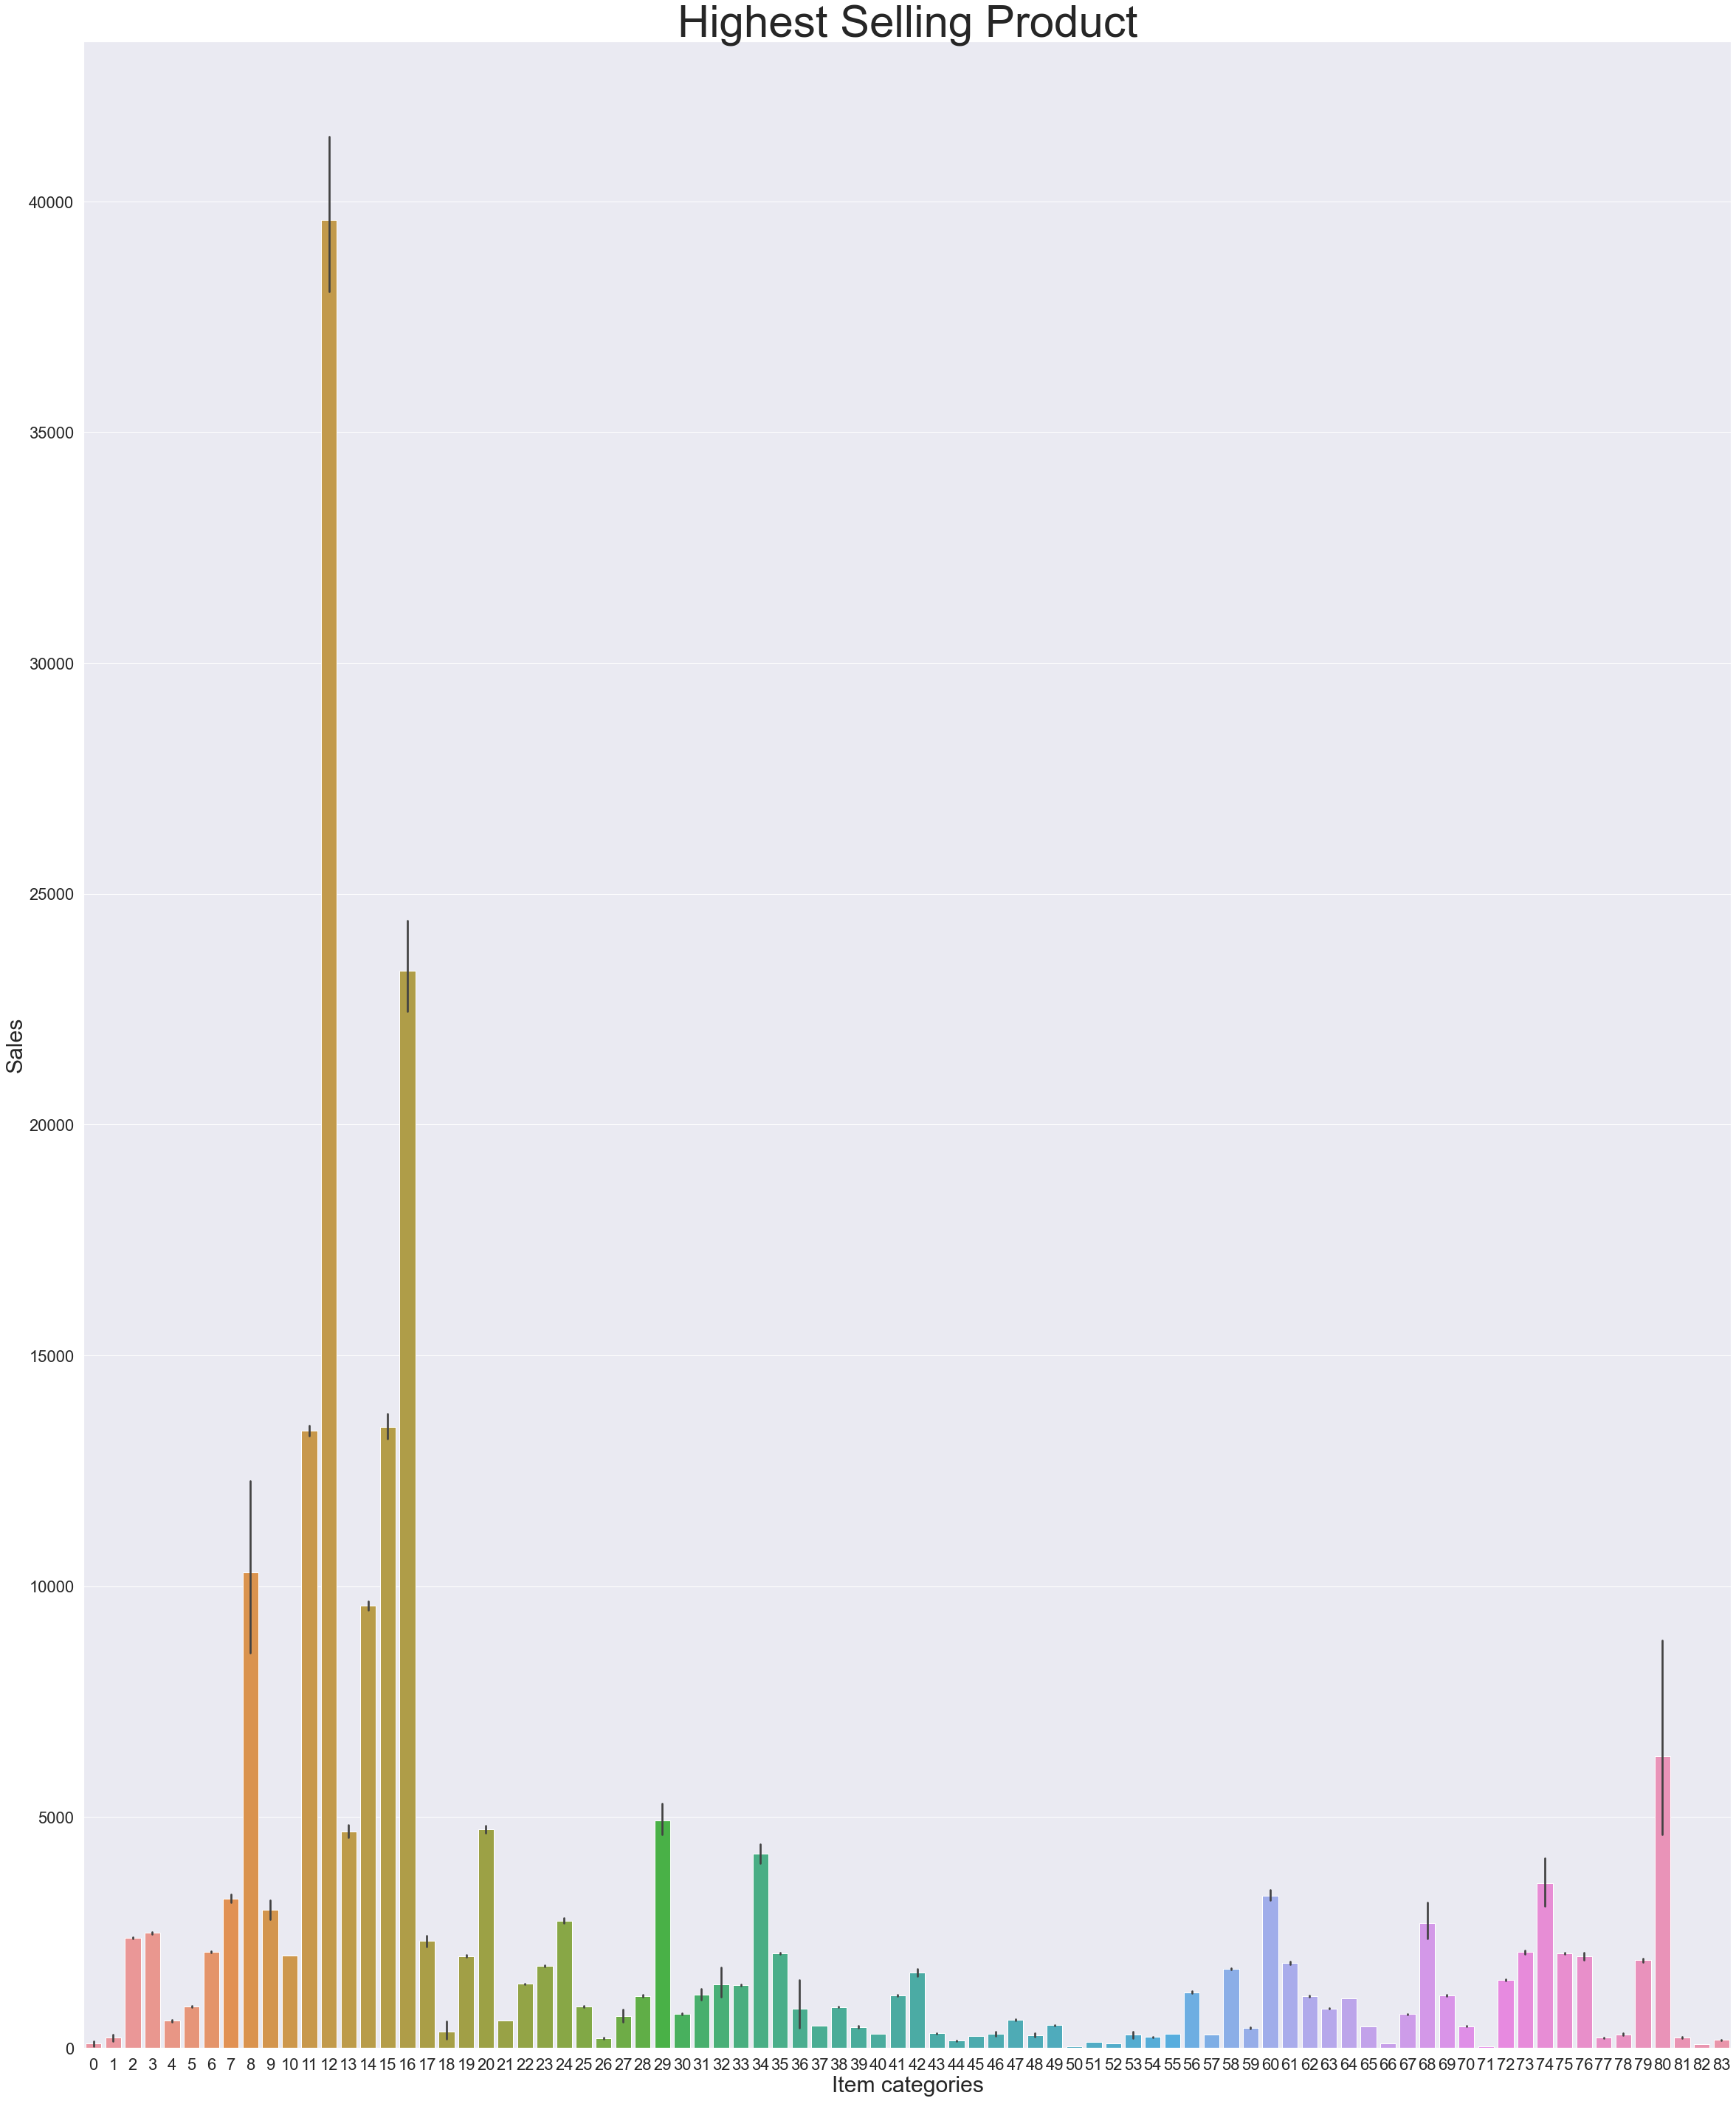

In [210]:
plt.figure(figsize=(40, 50))
x= train_set['item_category_id']
y= train_set['Sales']
sns.barplot(x, y)
plt.title('Highest Selling Product', fontsize = 60)
plt.xlabel('Item categories', fontsize = 30)
plt.ylabel('Sales', fontsize = 30)
plt.show()

The highest selling item category is 12, lets further explore the item_category_id 12

In [211]:
highest_selling_itemc= train_set.loc[train_set['item_category_id'] == 12]
highest_selling_itemc

,shop_name,shop_id,item_category_name,item_category_id,item_name,item_id,date,date_block_num,item_price,item_cnt_day,Sales
16947,"Адыгея ТЦ ""Мега""",2,Игровые консоли - PS4,12,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,6675,2013-11-29,10,18323.333333,30.0,549699.999999
16948,"Адыгея ТЦ ""Мега""",2,Игровые консоли - PS4,12,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,6675,2013-11-30,10,17990.000000,5.0,89950.000000
16949,"Адыгея ТЦ ""Мега""",2,Игровые консоли - PS4,12,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,6675,2013-12-27,11,22990.000000,2.0,45980.000000
16950,"Адыгея ТЦ ""Мега""",2,Игровые консоли - PS4,12,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,6675,2013-12-28,11,27990.000000,2.0,55980.000000
16951,"Адыгея ТЦ ""Мега""",2,Игровые консоли - PS4,12,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,6675,2013-12-29,11,27990.000000,2.0,55980.000000
...,...,...,...,...,...,...,...,...,...,...,...
2895033,"Ярославль ТЦ ""Альтаир""",59,Игровые консоли - PS4,12,Комплект Sony PS4 (500 Gb) Black (CUH-1108A/B0...,13444,2014-09-15,20,22490.000000,1.0,22490.000000
2895034,"Ярославль ТЦ ""Альтаир""",59,Игровые консоли - PS4,12,Комплект Sony PS4 (500 Gb) Black (CUH-1108A/B0...,13444,2014-04-10,21,22490.000000,1.0,22490.000000
2895035,"Ярославль ТЦ ""Альтаир""",59,Игровые консоли - PS4,12,Комплект «Sony PS4 (500 Gb) Black (CUH-1108A/B...,13498,2014-11-17,22,20990.000000,1.0,20990.000000
2895036,"Ярославль ТЦ ""Альтаир""",59,Игровые консоли - PS4,12,Комплект «Sony PS4 (500 Gb) Black (CUH-1108A/B...,13498,2014-01-11,22,22490.000000,1.0,22490.000000


The highest selling item category is Игровые консоли - PS4

### To find the shop with highest total sales

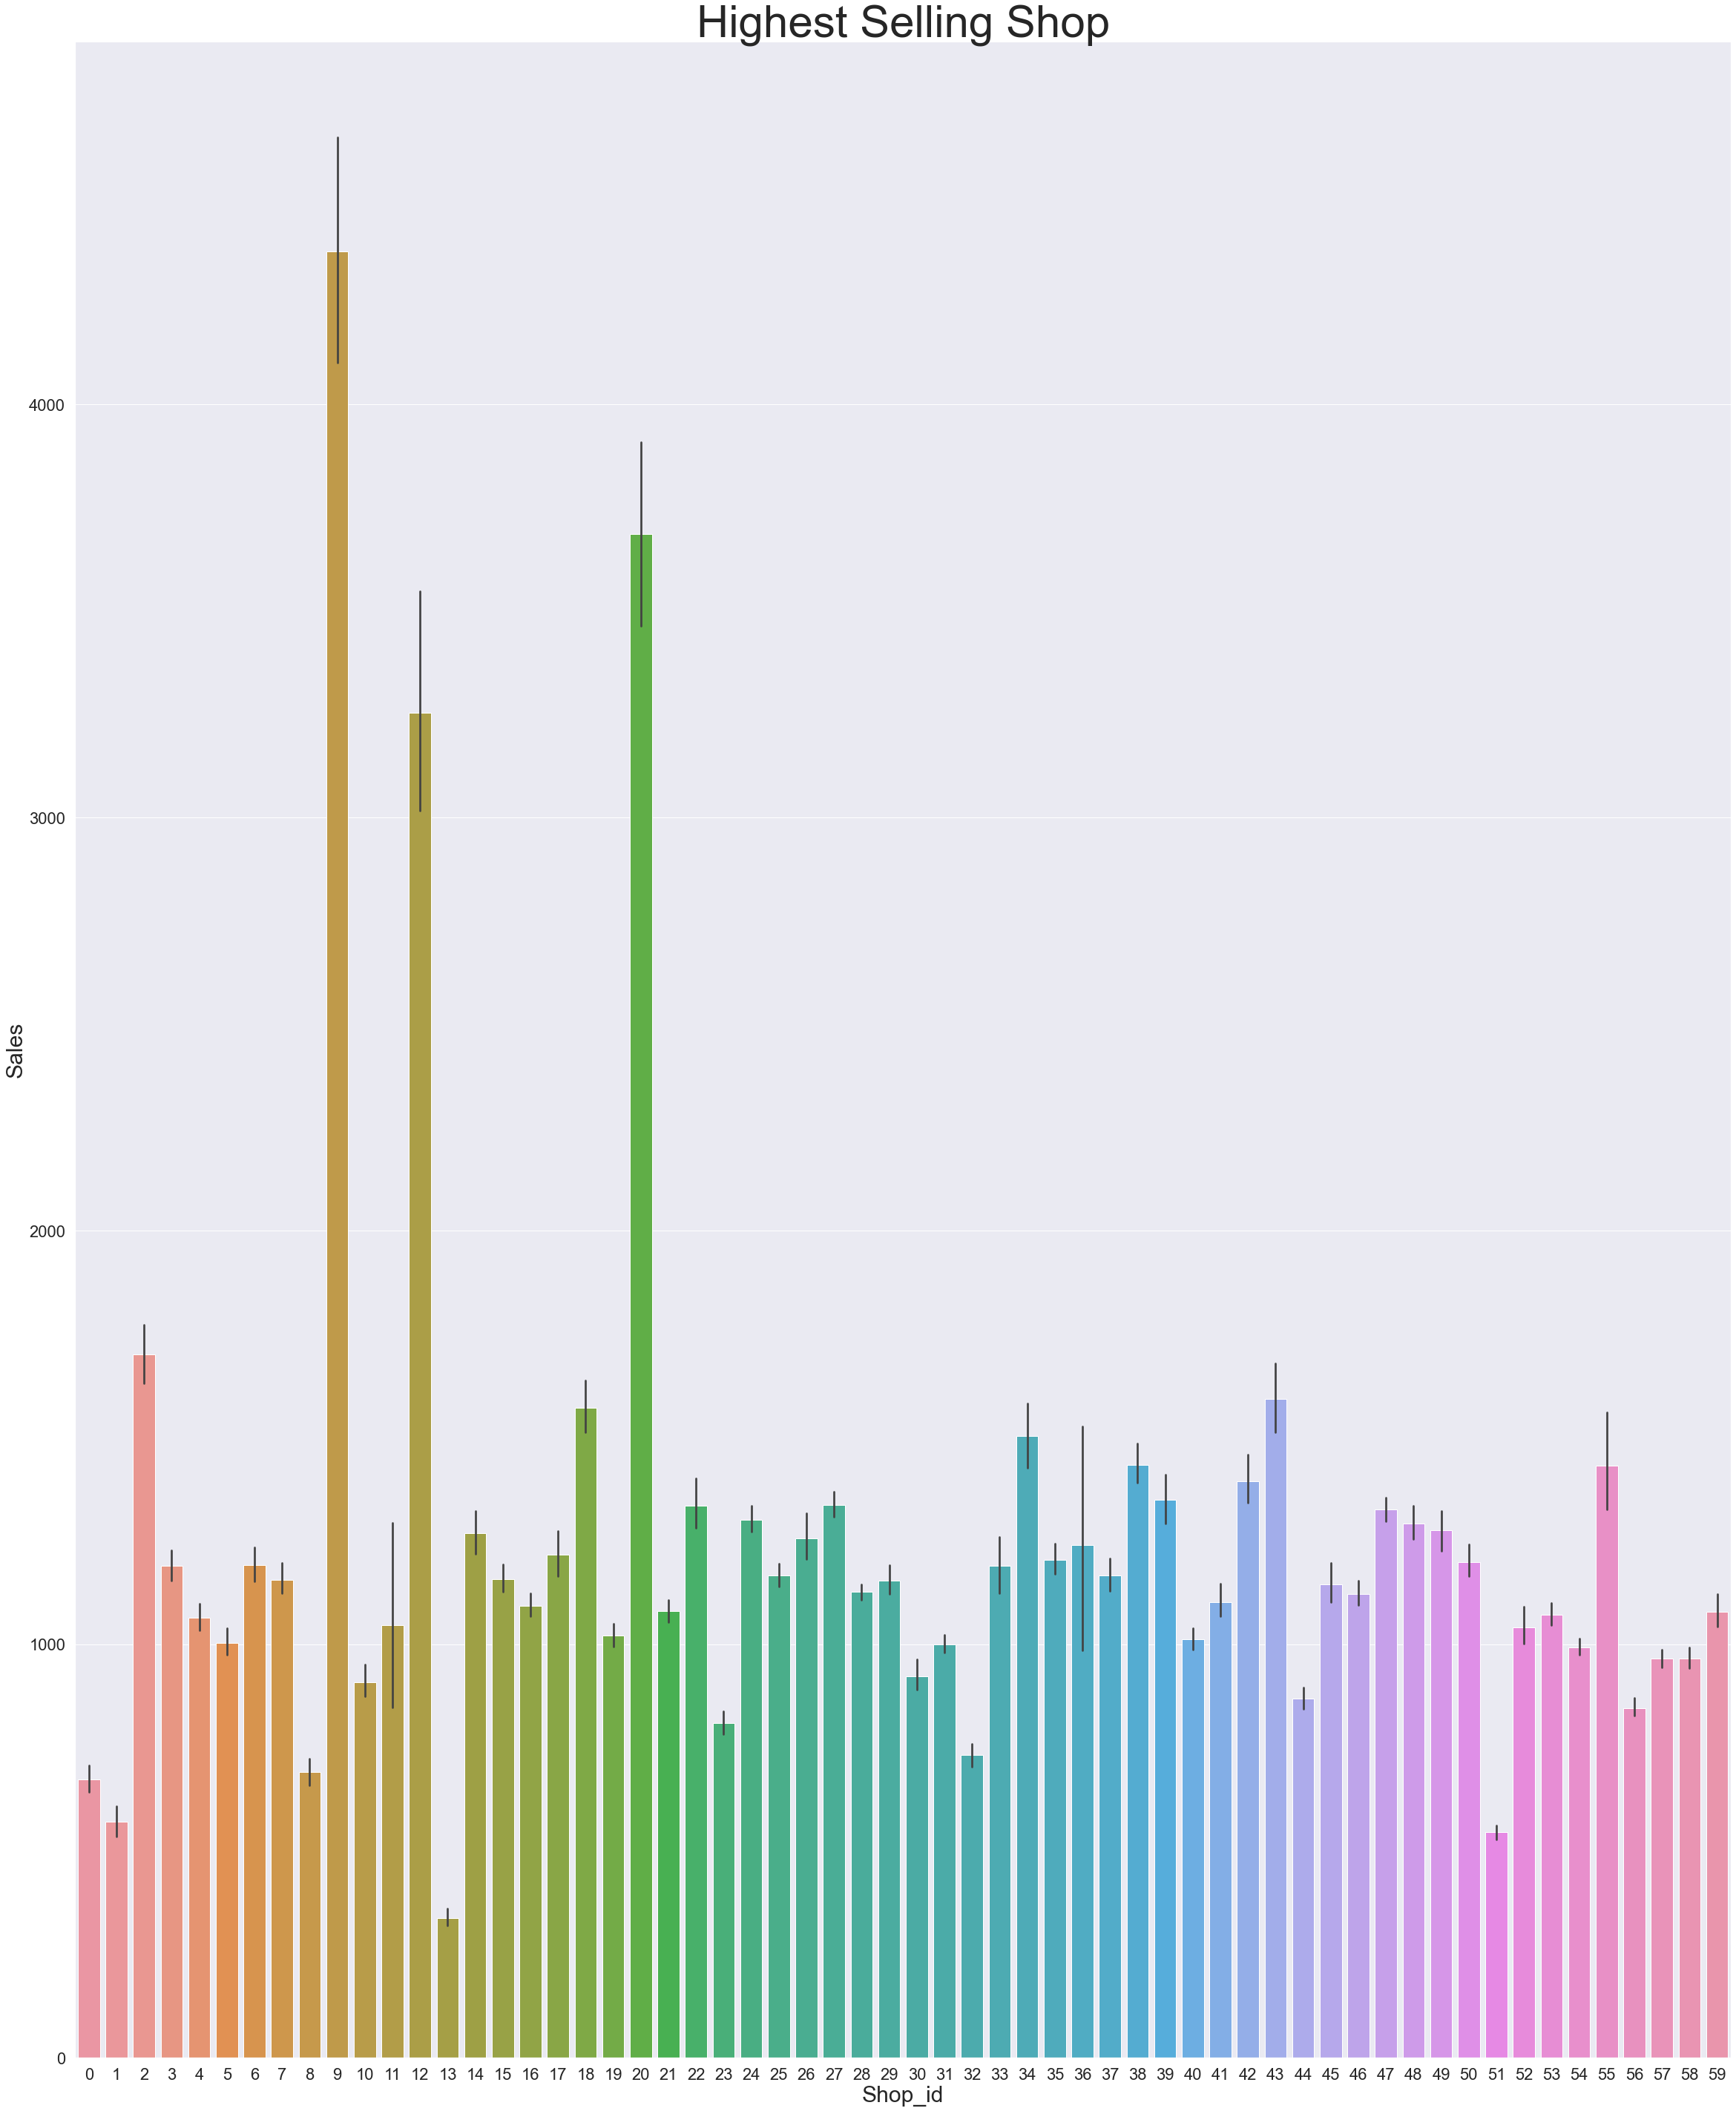

In [212]:
plt.figure(figsize=(40, 50))
x= train_set['shop_id']
y= train_set['Sales']
sns.barplot(x, y)
plt.title('Highest Selling Shop', fontsize = 60)
plt.xlabel('Shop_id', fontsize = 30)
plt.ylabel('Sales', fontsize = 30)
plt.show()

The highest selling shop has the id of 9

In [213]:
highest_selling_shop= train_set.loc[train_set['shop_id'] == 9]
highest_selling_shop

,shop_name,shop_id,item_category_name,item_category_id,item_name,item_id,date,date_block_num,item_price,item_cnt_day,Sales
287630,Выездная Торговля,9,Аксессуары - PS3,2,PS Move Motion Controller (Контроллер движений...,5572,2013-05-10,9,1490.000000,2.0,2980.0
287631,Выездная Торговля,9,Аксессуары - PS3,2,PS Move Motion Controller Charger (Зарядная ст...,5573,2013-04-10,9,599.000000,1.0,599.0
287632,Выездная Торговля,9,Аксессуары - PS3,2,PS Move Motion Controller Charger (Зарядная ст...,5573,2013-05-10,9,599.000000,2.0,1198.0
287633,Выездная Торговля,9,Аксессуары - PS3,2,PS3: Гарнитура беспроводная для PS3 (Wireless ...,5612,2013-04-10,9,3690.000000,1.0,3690.0
287634,Выездная Торговля,9,Аксессуары - PS3,2,PS3: Гарнитура беспроводная для PS3 (Wireless ...,5612,2013-06-10,9,3690.000000,1.0,3690.0
...,...,...,...,...,...,...,...,...,...,...,...
291376,Выездная Торговля,9,Программы - Для дома и офиса,75,Kaspersky Internet Security для Android Russia...,4201,2015-02-10,33,399.000000,110.0,43890.0
291377,Выездная Торговля,9,Служебные,79,Прием денежных средств для 1С-Онлайн,17717,2014-02-10,21,1999.000000,2.0,3998.0
291378,Выездная Торговля,9,Служебные,79,Прием денежных средств для 1С-Онлайн,17717,2014-03-10,21,1219.000000,5.0,6095.0
291379,Выездная Торговля,9,Служебные,79,Прием денежных средств для 1С-Онлайн,17717,2014-05-10,21,774.250000,4.0,3097.0


The highest selling shop is Выездная Торговля

#### The highest selling shop is Выездная Торговля

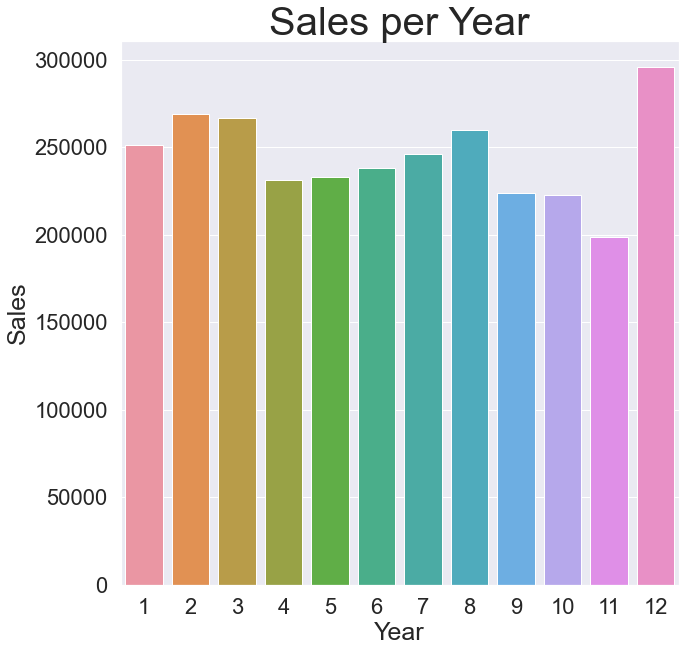

In [214]:
plt.figure(figsize=(10,10))
sns.countplot(months)
plt.title('Sales per Year', fontsize = 40)
plt.xlabel('Year', fontsize = 25)
plt.ylabel('Sales', fontsize = 25)
plt.show()

### To find the month from Jan 2013- Oct 2013 which had the highest sales

Text(0, 0.5, 'Sales')

<Figure size 2160x2160 with 0 Axes>

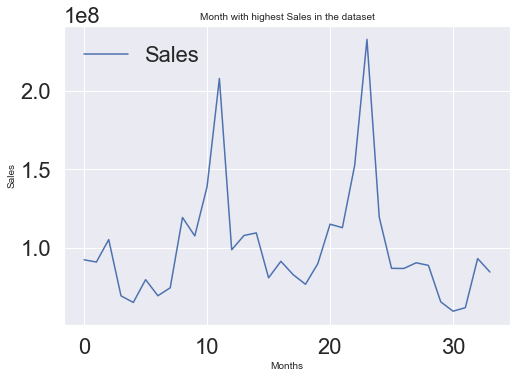

In [215]:
sales_by_month = train_set.groupby(['date_block_num'])[["Sales"]].sum()
plt.figure(figsize=(30,30))
sales_by_month.plot()
plt.title('Month with highest Sales in the dataset', fontsize = 10)
plt.xlabel('Months', fontsize = 10)
plt.ylabel('Sales', fontsize = 10)

In [216]:
sales_max = train_set.groupby(['date_block_num'])['Sales'].sum()
sales_max.max()

232615420.90999922

In [217]:
print(sales_max==232615420.90999845)

date_block_num
0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
Name: Sales, dtype: bool


The highest sale was in the 23 date block. Lets explore the date block 23.

In [218]:
highest_sales_month = train_set[train_set["date_block_num"]==23]
highest_sales_month


,shop_name,shop_id,item_category_name,item_category_id,item_name,item_id,date,date_block_num,item_price,item_cnt_day,Sales
15563,"Адыгея ТЦ ""Мега""",2,Аксессуары - PS3,2,PS Move Motion Controller (Контроллер движений...,5572,2014-12-18,23,1490.0,1.0,1490.0
15627,"Адыгея ТЦ ""Мега""",2,Аксессуары - PS3,2,PS3: Turtle Beaсh. EarForce P11. Геймерская ст...,5610,2014-12-31,23,1890.0,1.0,1890.0
15652,"Адыгея ТЦ ""Мега""",2,Аксессуары - PS3,2,PS3: Геймпад Gioteck VX-1 беспроводной (VX1PS3...,5616,2014-12-29,23,1190.0,1.0,1190.0
15699,"Адыгея ТЦ ""Мега""",2,Аксессуары - PS3,2,PS3: Контроллер игровой беспроводной красный (...,5631,2014-12-31,23,3290.0,1.0,3290.0
15712,"Адыгея ТЦ ""Мега""",2,Аксессуары - PS3,2,PS3: Контроллер игровой беспроводной прозрачны...,5634,2014-12-16,23,2590.0,1.0,2590.0
...,...,...,...,...,...,...,...,...,...,...,...
2935789,"Ярославль ТЦ ""Альтаир""",59,Элементы питания,83,Элемент питания DURACELL TURBO LR 03 2*BL,22091,2014-12-14,23,139.0,1.0,139.0
2935790,"Ярославль ТЦ ""Альтаир""",59,Элементы питания,83,Элемент питания DURACELL TURBO LR 03 2*BL,22091,2014-07-12,23,139.0,1.0,139.0
2935840,"Ярославль ТЦ ""Альтаир""",59,Элементы питания,83,Элемент питания DURACELL TURBO LR6 2*BL,22092,2014-12-21,23,139.0,1.0,139.0
2935841,"Ярославль ТЦ ""Альтаир""",59,Элементы питания,83,Элемент питания DURACELL TURBO LR6 2*BL,22092,2014-12-15,23,139.0,1.0,139.0


This shows that the highest sales were in the month of December 2014

#### To find the store which recorded highest sales in amonth from Jan 2013-Oct2015

In [219]:
highest_store_sales = train_set.groupby(['date_block_num', 'shop_name'])['Sales'].sum()

highest_store_sales.max()

15730394.000000525

In [220]:
highest_store_sales=pd.DataFrame(highest_store_sales)
highest_store_sales=highest_store_sales.loc[highest_store_sales['Sales'] == 15730394.000000501]
highest_store_sales

,,Sales
date_block_num,shop_name,


the store with the highest sales in a month from Jan 2013-Oct 2015 is Москва ТРК "Атриум"

### To find the item category which recorded highest sale in month from Jan 2013-Oct 2015

In [221]:
highest_item_sales = train_set.groupby(['date_block_num', 'item_category_name'])['Sales'].sum()

highest_item_sales.max()

46487721.9999976

In [222]:
highest_item_sales=pd.DataFrame(highest_item_sales)
highest_item_sales=highest_item_sales.loc[highest_item_sales['Sales'] == 46487721.9999976]
highest_item_sales

,,Sales
date_block_num,item_category_name,
11,Игровые консоли - PS4,4.648772e+07


The item selling highest in a given month is Игровые консоли - PS4

## To aggregate train data set to show monthly data to bring it in line with test data

In [223]:
train_set = train_set[["date_block_num", "shop_id", "item_id", "item_price", "item_cnt_day", "shop_name", "Sales", "item_name"]].groupby(
    ["date_block_num", "shop_id", "item_id"]).agg(
    {"item_cnt_day": "sum", "Sales" : "sum"}).reset_index()
train_set.rename(columns={"item_cnt_day": "item_cnt_month"}, inplace=True)

#### To merge the test data with other datasets.

In [224]:
test1=pd.merge(items, sales_test)
test2=pd.merge(items_cat, test1)
test = pd.merge(shops,test2)
test

,shop_name,shop_id,item_category_name,item_category_id,item_name,item_id,ID
0,"Адыгея ТЦ ""Мега""",2,PC - Гарнитуры/Наушники,0,PC: Гарнитура HyperX Cloud Core игровая стерео...,5441,23914
1,"Адыгея ТЦ ""Мега""",2,Аксессуары - PS3,2,PS Move Motion Controller (Контроллер движений...,5572,24116
2,"Адыгея ТЦ ""Мега""",2,Аксессуары - PS3,2,PS3: Кабель HDMI Artplays 2 м (ver. 1.4) блистер,5621,25398
3,"Адыгея ТЦ ""Мега""",2,Аксессуары - PS3,2,PS3: Контроллер игровой беспроводной прозрачны...,5634,21533
4,"Адыгея ТЦ ""Мега""",2,Аксессуары - PS3,2,PS3: Контроллер игровой беспроводной серый мет...,5637,25197
...,...,...,...,...,...,...,...
214195,"Ярославль ТЦ ""Альтаир""",59,Служебные,79,Прием денежных средств для 1С-Онлайн,17717,148174
214196,"Ярославль ТЦ ""Альтаир""",59,Элементы питания,83,Элемент питания DURACELL LR03-BC2,22087,148487
214197,"Ярославль ТЦ ""Альтаир""",59,Элементы питания,83,Элемент питания DURACELL LR06-BC2,22088,148488
214198,"Ярославль ТЦ ""Альтаир""",59,Элементы питания,83,Элемент питания DURACELL TURBO LR 03 2*BL,22091,148489


### To drop the insignificant column ID because the same information is captured in shopi_id and item_id

In [225]:
test=test.drop("ID",1)

### To explore the basic structure of test data set.

In [226]:
test.shape

(214200, 6)

### To align train data set with test. It is mentioned that we need to predict the sales of products and shops present in the test data set, therefore we need to check the dimenions of shop_id and item_id between train and test data set.

In [227]:
train_set_u = train_set['item_id'].nunique()
test_u = test['item_id'].nunique()
train_set_s = train_set['shop_id'].nunique()
test_s = test['shop_id'].nunique()
print("Total unique item_ids in train_set dataset: ", train_set_u)
print("Total unique item_ids in test dataset: ", test_u )

print("Total unique shop_ids train_set dataset: ", train_set_s)
print("Total unique shop_ids in test dataset: ", test_s)

Total unique item_ids in train_set dataset:  21806
Total unique item_ids in test dataset:  5100
Total unique shop_ids train_set dataset:  60
Total unique shop_ids in test dataset:  42


### To remove additional products and shops from the train data set.

In [228]:
train_set = train_set[train_set['shop_id'].isin(test['shop_id'].unique())]
train_set = train_set[train_set['item_id'].isin(test['item_id'].unique())]

### To verify again¶

In [229]:
train_set_u = train_set['item_id'].nunique()
test_u = test['item_id'].nunique()
train_set_s = train_set['shop_id'].nunique()
test_s = test['shop_id'].nunique()
print("Total unique item_ids in train_set dataset: ", train_set_u)
print("Total unique item_ids in test dataset: ", test_u )

print("Total unique shop_ids train_set dataset: ", train_set_s)
print("Total unique shop_ids in test dataset: ", test_s)

Total unique item_ids in train_set dataset:  4716
Total unique item_ids in test dataset:  5100
Total unique shop_ids train_set dataset:  42
Total unique shop_ids in test dataset:  42


##### Notice now we have some item_ids not present in the train data set which would make it difficult to predict the sales because we don't have the information for these item_ids in train data set.

### Create a reduced version of test and train to compare with full data set features

In [230]:
test.shape

(214200, 6)

In [231]:
test["item_cnt_month"]=" "

In [232]:
test.info()
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   shop_name           214200 non-null  object
 1   shop_id             214200 non-null  int64 
 2   item_category_name  214200 non-null  object
 3   item_category_id    214200 non-null  int64 
 4   item_name           214200 non-null  object
 5   item_id             214200 non-null  int64 
 6   item_cnt_month      214200 non-null  object
dtypes: int64(3), object(4)
memory usage: 13.1+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 600158 entries, 3921 to 1609121
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date_block_num  600158 non-null  int64  
 1   shop_id         600158 non-null  int64  
 2   item_id         600158 non-null  int64  
 3   item_cnt_month  600158 non-null  float64
 4   Sal

In [233]:
# To drop some insignificant columns
train_set=train_set.drop("Sales", 1)
train_set=train_set.drop("date_block_num", 1)
test= test.drop("item_category_id", 1)
test= test.drop("item_category_name", 1)
test= test.drop("item_name", 1)
test= test.drop("shop_name", 1)

In [239]:
test.shape

(214200, 3)

### Training models

In [234]:
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
from xgboost import XGBRFRegressor

In [235]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, train_test_split, RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost
from xgboost import XGBClassifier
import yellowbrick
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [236]:
# splitting data
X = train_set.drop(['item_cnt_month'], axis=1)
y_train = train_set['item_cnt_month']
X_test = test.drop(['item_cnt_month'], axis=1)

In [243]:
X_train = train_set.drop(['item_cnt_month'], axis=1)
y_train = train_set['item_cnt_month']
x_test = test.drop(['item_cnt_month'], axis=1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

#### Gradient boosting

In [241]:
GBReg = GradientBoostingRegressor(n_estimators=200, max_depth=11, random_state=100).fit(X_train, y_train)
print('R-squared of the training: {:.3f}'.format(GBReg.score(X_train, y_train)))

R-squared of the training: 0.666


In [247]:
LinReg = LinearRegression().fit(X_train, y_train)
print('R-squared of the training: {:.3f}'.format(LinReg.score(X_train, y_train)))


R-squared of the training: 0.000


In [245]:
RidgeReg = Ridge().fit(X_train, y_train)
print('R-squared of the training: {:.3f}'.format(RidgeReg.score(X_train, y_train)))

R-squared of the training: 0.000


### LGBMRegressor Model¶

In [240]:
train_x = train_set.drop(['item_cnt_month'], axis=1)
train_y = train_set['item_cnt_month']
test_x = test.drop(['item_cnt_month'], axis=1)
model_lgb = LGBMRegressor(colsample_bytree=0.9, learning_rate=0.03, max_depth=6,
              min_child_weight=1, min_split_gain=0.0222415, n_estimators=100,
              num_leaves=32, reg_alpha=0.04, reg_lambda=0.073,
              subsample=0.9)
model_lgb.fit(X_train, y_train)


LGBMRegressor(colsample_bytree=0.9, learning_rate=0.03, max_depth=6,
              min_child_weight=1, min_split_gain=0.0222415, num_leaves=32,
              reg_alpha=0.04, reg_lambda=0.073, subsample=0.9)

### Predition

In [ ]:
sales_prediction = GBReg.predict(X_test)
sales_prediction

### Submission

In [ ]:
sales_predict_submission = pd.DataFrame({'ID':X_test.index,'item_cnt_month':sales_prediction})

In [ ]:
sales_predict_submission

In [ ]:
 sales_predict_submission.to_csv('./fsubmission.csv', index= False, header= 1)